In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy 
from astropy.io import fits, ascii
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-9999.0)&(r13['LOGG']>0.0)&\
                (r13['M_H_ERR']>-90.0)&(r13['C_FE']>-9999.0)&(r13['N_FE']>-9999.0))

r13 = r13[clnr]

#Transform APOGEE RA and DEC to Magellanic Stream L and B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

In [5]:
##############
### Fields ###
##############

field_str = ['30Dor','LMC1','LMC2','LMC3','LMC4','LMC5','LMC6','LMC7','LMC8','LMC9','LMC10','LMC11','LMC12',
             'LMC13','LMC14','LMC15','LMC16','LMC17']

In [6]:
### blue loop cut
bloop = np.where((r13['TEFF']>=4100)&(r13['H']<=13.0)&((r13['J']-r13['K'])<=0.95))

bloop_cut = []
for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
bloopr13 = r13[bloop_cut]

fields = []
for i in range(len(field_str)):
    fields.append(np.where(bloopr13['FIELD']==field_str[i]))

In [7]:
def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# Age Bins

In [29]:
### PCA Plus OLS
def find_ages(z1,z2,z3):
    p = [9.39183782e+00,6.21217819e-02,4.29593576e-02,-2.95816612e+00,-1.43014007e-02,-6.47435954e-02,
         -5.99196415e-02,-5.84656083e-03,1.71370300e-02,8.66227116e-01,-2.01258347e-02]
#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
    return age

#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
#     return age

# # def find_ages(z1,z2):
# #     p = [9.41292724,0.05706436,-2.70513596]
# #     return p[0]+p[1]*z1+p[2]*z2

# from sklearn.decomposition import PCA
# pdat = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

In [14]:
# ######################
# ### Calculate Ages ###
# ######################

# abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
# keys = list(abd.keys())

# sol_2_H = []
# for i in keys:
#     sol_2_H.append(abd[i]-12.0)
    
# sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
# x_C = []
# x_N = []
# x_O = []
# x_Mg = []
# x_Ca = []
# x_S = []
# x_Si = []
# x_Fe = []

# for i in range(len(r13)):
#     x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))
    
# factsCN = []
# for j in range(len(r13)):
#     numerCN = x_C[j]+x_N[j]
#     denomCN = sum(sol_xm[0:2])
    
# factsCN.append(numerCN/denomCN)
# factsCN = factsCN

# metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

# xLMC, yLMC, stardist = dfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
# corabsK = dfunc.absmag(r13['K'],stardist)-r13['AK_TARG']

# adat = np.array([np.log10(r13['TEFF']),corabsK,dfunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T

# zs = PCA(n_components=3).fit(pdat).transform(adat)

# parage = find_ages(zs[:,0],zs[:,1],zs[:,2])

# bloopage = np.asarray(parage)[bloop_cut]
# bloopabsH = (dfunc.absmag(r13['H'],stardist)-r13['AK_TARG'])[bloop_cut]

In [30]:
### Model
# def find_ages(z1,z2,z3):
#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
#     return age
#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
#     return age

### PCA 
from sklearn.decomposition import PCA
pdat = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Zini']/0.02),parsec['logg']]).T


### Solar X
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))

In [31]:
####################################
### Get Uncertainties: Add Noise ###
####################################

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [32]:
age_dist = []

pca_transform = PCA(n_components=3).fit(pdat)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = dfunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = dfunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,dfunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in range(len(age_dist)):
    devs.append(dfunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

In [12]:
parage = np.asarray(parages.copy())
devs = np.asarray(devs)

In [33]:
young = np.where(np.asarray(parages)[bloop_cut]<=np.log10(0.5*10**9))

In [34]:
len(np.squeeze(young))

93

In [13]:
# ################################
# ### Calculate  Uncertainties ###
# ################################

# noisy = []
# # halo_cutoff = -1.5

# pca_transform = PCA(n_components=3).fit(pdat)

# for i in tqdm_notebook(range(len(r13)),desc='Done?'):
#     # temperature
#     teff = r13['TEFF'][i]
#     teff_err = r13['TEFF_ERR'][i]
    
#     # photometry 
#     ra = r13['RA'][i]
#     dec = r13['DEC'][i]
#     ks = r13['K'][i]
#     ks_err = r13['K_ERR'][i]
#     ak = r13['AK_TARG'][i]
    
#     # abundances
#     mh = r13['M_H'][i]
#     mh_err = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfe_err = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfe_err = r13['N_FE_ERR'][i]
#     feh = r13['FE_H'][i]
#     feh_err = r13['FE_H_ERR'][i]
    
#     # surface gravity
#     lgg = r13['LOGG'][i]
#     lgg_err = r13['LOGG_ERR'][i]
    
#     noise_ages = []
#     new = []
#     for j in range(1000):
       
#         # calculate noisy temperature
#         teff_new = add_noise(teff,teff_err) 
#         lgteff_new = np.log10(teff_new)
    
#         # Calculate noisy K magnitude
#         _, _, dist = dfunc.LMCdisk_cart(ra,dec)
        
#         ks_new = add_noise(ks,ks_err)
        
# #         if feh <= halo_cutoff:
# #             dist_new = add_noise(dist,1.0,distribution='uniform')
# #             absK_new = dfunc.absmag(ks_new,dist_new) - ak
        
# #         else:
# #             absK_new = dfunc.absmag(ks_new,dist) - ak
            
#         absK_new = dfunc.absmag(ks_new,dist) - ak
            
#         # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
#         ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
#         mh_new = add_noise(mh,mh_err)
        
#         # Calculate noisy surface gravity
#         lgg_new = add_noise(lgg,lgg_err)
            
#         # calculate noisy age
#         new.append(np.array([lgteff_new,absK_new,dfunc.sal(mh_new,ffac_new),lgg_new]))
        
#     zs = pca_transform.transform(np.asarray(np.squeeze(new)))
        
# #     noise_ages.append(find_ages(zs[0],zs[1],zs[2]))
    

#     for l in range(len(zs)):
#         noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))#noise_ages)
    
#     noisy.append(noise_ages)
    
# devs = []
# for k in range(len(noisy)):
#     devs.append(dfunc.mad(noisy[k]))
    
# devs = np.asarray(devs)[bloop_cut]

In [14]:
# ################################
# ### Calculate  Uncertainties ###
# ################################

# devs = []
# devscat = []
# halo_cutoff = -1.53

# for i in tqdm_notebook(range(len(r13)),desc='Done?'):
#     # temperature
#     teff = r13['TEFF'][i]
#     teff_err = r13['TEFF_ERR'][i]
    
#     # photometry 
#     ra = r13['RA'][i]
#     dec = r13['DEC'][i]
#     ks = r13['K'][i]
#     ks_err = r13['K_ERR'][i]
#     ak = r13['AK_TARG'][i]
    
#     # abundances
#     mh = r13['M_H'][i]
#     mh_err = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfe_err = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfe_err = r13['N_FE_ERR'][i]
#     feh = r13['FE_H'][i]
#     feh_err = r13['FE_H_ERR'][i]
    
#     # surface gravity
#     lgg = r13['LOGG'][i]
#     lgg_err = r13['LOGG_ERR'][i]
    
#     noise_ages = []
#     for j in range(1000):
       
#         # calculate noisy temperature
#         teff_new = add_noise(teff,teff_err) 
#         lgteff_new = np.log10(teff_new)
    
#         # Calculate noisy K magnitude
#         _, _, dist = dfunc.LMCdisk_cart(ra,dec)
        
#         ks_new = add_noise(ks,ks_err)
        
#         if feh <= halo_cutoff:
#             dist_new = add_noise(dist,1.0,distribution='uniform')
#             absK_new = dfunc.absmag(ks_new,dist_new) - ak
        
#         else:
#             absK_new = dfunc.absmag(ks_new,dist) - ak
            
#         # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
#         ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
#         mh_new = add_noise(mh,mh_err)
        
#         # Calculate noisy surface gravity
#         lgg_new = add_noise(lgg,lgg_err)
            
#         # calculate noisy age
#         new = np.array([lgteff_new,absK_new,dfunc.sal(mh_new,ffac_new),lgg_new]).T
        
#         noise_ages.append(find_ages(new[0],new[1],new[2]))
    
#     devs.append(dfunc.mad(noise_ages))
#     devscat.append(dfunc.mad(noise_ages))

# devs = np.asarray(devs)[bloop_cut]

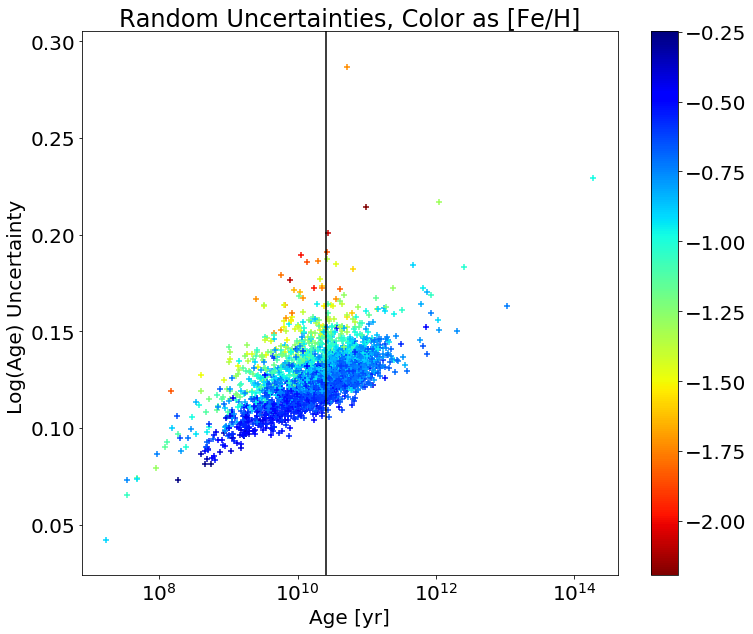

In [15]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parage[bloop_cut]),devs[bloop_cut],marker='+',c=r13['FE_H'][bloop_cut],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.max(devs[bloop_cut])),c='k')
plt.xscale('log')
# plt.ylim(0.05,0.8)
# plt.xlim(left=10**5)
plt.title(r'Random Uncertainties, Color as [Fe/H]')
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty ')
plt.show()

In [27]:
#####################
### Make age Bins ###
#####################

young = np.where(parage[bloop_cut]<=np.log10(0.5*10**9))
yless = np.where((parage[bloop_cut]>np.log10(0.5*10**9))&(parage[bloop_cut]<=np.log10(2.0*10**9)))
ymed = np.where((parage[bloop_cut]>np.log10(2.0*10**9))&(parage[bloop_cut]<=np.log10(7*10**9)))
omed = np.where((parage[bloop_cut]>np.log10(7*10**9))&(parage[bloop_cut]<=np.log10(10.5*10**9)))
old = np.where(parage[bloop_cut]>np.log10(10.5*10**9))

r13young = bloopr13[young]
r13yless = bloopr13[yless]
r13ymed = bloopr13[ymed]
r13omed = bloopr13[omed]
r13old = bloopr13[old]

xLMC, yLMC, stardist = dfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
bloopage = np.asarray(parages)[bloop_cut]
bloopabsH = (dfunc.absmag(r13['H'],stardist)-r13['AK_TARG'])[bloop_cut]

In [28]:
len(r13young)

34

In [18]:
len(parage)

2588

# Density Calculation

In [25]:
########################
### Area Calculation ###
########################

### pc^2
field_ang = [0.8,0.95,0.95,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.95,0.8,0.8,0.8,0.95,0.8]
field_areas = np.multiply(np.pi*np.square(np.multiply(field_ang,0.875)),10**6)

###################################
### Calculate the fields masses ###
###################################

iso_ages = []
iso_zs = []

#fnt and brt bins
fbins = dfunc.brtfntlmc_bins(bloopr13)

for i in range(len(field_str)):
    fd = np.where(bloopr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(bloopage[fd]),np.median(bloopr13[fd]['FE_H']))
    iso_ages.append(age)
    iso_zs.append(z)

absHs = []
for i in range(len(field_str)):
    field_H = np.where(bloopr13['FIELD']==field_str[i]) 
    absHs.append(np.asarray(bloopabsH)[field_H])

sf_brites = []
sf_faints = []

for i in field_str:
    fld = np.where(bloopr13['FIELD']==i)
    
    fnts = np.where(bloopr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(bloopr13['TARGET_NAME'][fld]=='BrtRGB')
    
    sf_faints.append(bloopr13['SELECTFUNC'][fld][fnts])
    sf_brites.append(bloopr13['SELECTFUNC'][fld][brts])
    
# for i,j in enumerate(fbins):
#     if i in np.arange(len(fbins))[1::2]:
#         sf_brites.append(bloopr13[fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(fbins))[0::2]:
#         sf_faints.append(bloopr13[fbins[j]]['SELECTFUNC'])
        
        
field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    field_masses.append(dfunc.fieldmass(iso_ages[i],iso_zs[i],absHs[i],sf_brites[i],sf_faints[i],parsec))
print(field_masses)

NameError: name 'bloopabsH' is not defined

In [20]:
### Calculate Surface Densities and Density Profile

import statsmodels.api as sm

surfden = []
for i in range(len(field_masses)):
    surfden.append(np.divide(field_masses[i],field_areas[i]))
    
'''
model is sigma = A*exp(B*r)
A central density 
B radial scale height 
r radius

ln(sigma) = lnA + B*r
'''

import statsmodels.api as sm 

field_list = [np.where(bloopr13['FIELD']=='30Dor'),np.where(bloopr13['FIELD']=='LMC1'),
              np.where(bloopr13['FIELD']=='LMC2'),np.where(bloopr13['FIELD']=='LMC3'),
              np.where(bloopr13['FIELD']=='LMC4'),np.where(bloopr13['FIELD']=='LMC5'),
              np.where(bloopr13['FIELD']=='LMC6'),np.where(bloopr13['FIELD']=='LMC7'),
              np.where(bloopr13['FIELD']=='LMC8'),np.where(bloopr13['FIELD']=='LMC9'),
              np.where(bloopr13['FIELD']=='LMC10'),np.where(bloopr13['FIELD']=='LMC11'),
              np.where(bloopr13['FIELD']=='LMC12'),np.where(bloopr13['FIELD']=='LMC13'),
              np.where(bloopr13['FIELD']=='LMC14'),np.where(bloopr13['FIELD']=='LMC15'),
              np.where(bloopr13['FIELD']=='LMC16'),np.where(bloopr13['FIELD']=='LMC17')]

radii = []

x, y, _ = dfunc.LMCdisk_cart(bloopr13['RA'],bloopr13['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
#     radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(bloopr13['RA'][field_list[i]],
#                                                       bloopr13['DEC'][field_list[i]])[0])**2 + 
#                          np.median(dfunc.LMCdisk_cart(bloopr13['RA'][field_list[i]],
#                                                       bloopr13['DEC'][field_list[i]])[1])**2))
    radii.append(np.median(ell[field_list[i]]))
    

model = np.array([radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(surfden),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(surfden)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

def lmcdensityprofile(r):
    p = [ 5.30458805, -0.66202375]
    return p[0]+np.multiply(p[1],r)

plt.figure(figsize=[12,10])

plt.scatter(radii,surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in range(len(radii)):
    plt.text(radii[i],surfden[i],'{}'.format(['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 
                                              'LMC8','LMC9', 'LMC10', 'LMC11', 'LMC12', 'LMC13', 'LMC14', 'LMC15',
                                              'LMC16', 'LMC17'][i]))
plt.plot(radii,np.exp(lmcdensityprofile(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title(r'Surface Density Profile for the LMC, h_R: {:.3f} +/- {:.3f}'.format(np.reciprocal(0.8287),
                                                                                0.093*np.reciprocal(0.8287**2)),
          fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile.pdf',bbox_inches='tight')
plt.show()

NameError: name 'field_masses' is not defined

In [26]:
import statsmodels.api as sm

def ols_fit(x,y):
    '''
    Calculate OLS fit of a line aking use of statsmodels.api
    
    Parameters:
    ----------
        x: exog of line
        y: endog of line
    
    Returns:
    -------
        m: slope of OLS line
        b: intercept of OLS line
    '''
    
    # fit model
    model = np.array([x]).T
    model = sm.add_constant(model)
    model_fit = sm.OLS(y,model).fit()
    err = model_fit.bse[::-1]
    m = model_fit.params[1]
    b = model_fit.params[0]
    
    return m, b, err

In [27]:
# ols_fit(radii_rm30dor,np.log(surfden_rm30dor))

In [28]:
np.reciprocal(0.8867803249117395)

1.1276749967355546

## Remove 30 Dor

-0.8988124067193618


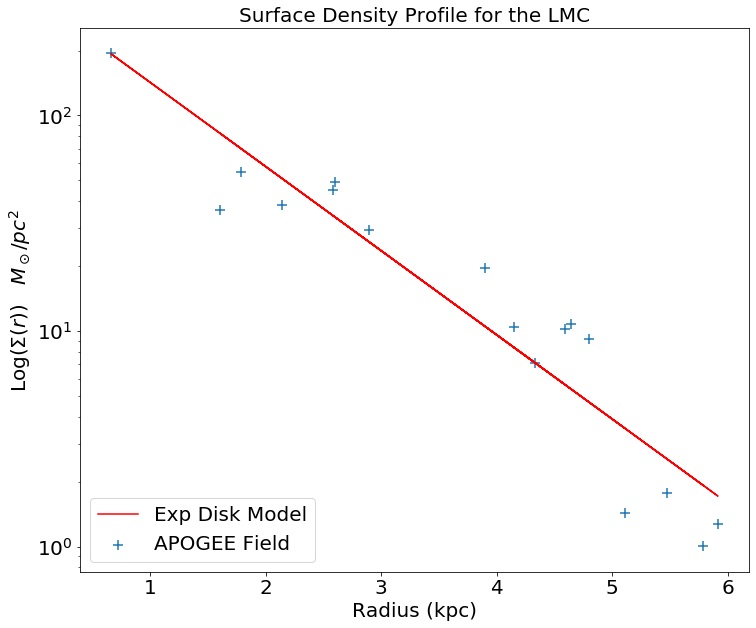

In [29]:
radii_rm30dor = np.delete(radii,0)
surfden_rm30dor = np.delete(surfden,0)

# model = np.array([radii_rm30dor]).T
# model = sm.add_constant(model)
# model_model = sm.OLS(np.log(surfden_rm30dor),model).fit()
# model_predictions = model_model.predict(model)
# model_residual = model_predictions - np.log(surfden_rm30dor)
# model_summary = model_model.summary()
# print(model_summary)
# print(np.asarray(model_model.params))

m, b,err = ols_fit(radii_rm30dor,np.log(surfden_rm30dor))
print(m)

# plt.figure(figsize=[12,10])
# plt.scatter(radii_rm30dor,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
# plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
# plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
# plt.title(r'Surface Density Residuals')
# plt.xlabel(r'Radius (kpc)')
# plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# # plt.colorbar()
# # plt.savefig('residexpmodel.pdf',bbox_inches='tight')
# plt.show()
# print('mad(Residual):',dfunc.mad(model_residual))

def lmcdensityprofile_rm30dor(r):
    return b+np.multiply(m,r)

plt.figure(figsize=[12,10])

plt.scatter(radii_rm30dor,surfden_rm30dor,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in np.delete(range(len(radii)),0):
#     plt.text(radii[i],surfden[i],'{}'.format(['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8',
#        'LMC9', 'LMC10', 'LMC11', 'LMC12', 'LMC13', 'LMC14', 'LMC15',
#        'LMC16', 'LMC17'][i]))
plt.plot(radii,np.exp(lmcdensityprofile_rm30dor(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile_rm30dor.pdf',bbox_inches='tight')
plt.show()

In [30]:
np.reciprocal(0.8988124067193618)

1.1125792128860013

In [31]:
# def trim_surfden(mass,area,radius):
#     '''
#     Calculate Surface density for a fields
    
#     Parameters:
#     ----------
#         mass: field mass
#         area: field area
#         radius: central radius of field to center of LMC
    
#     Returns:
#     -------
#         new_density: surface density with bad values removed
#         new_radius: radius with bad values removed
#         rm_values: indices of values removed
#     '''
    
#     # initialize outputs
#     density = []
#     new_radius = []
    
#     # surface density calculation
#     for i in range(len(mass)):
#         density.append(np.divide(mass[i],area[i]))
        
#     good = np.where(np.asarray(density)>0.0)
#     rm_values = np.where(np.asarray(density)<0.0)

#     new_radius = np.asarray(radius)[good]
#     new_density = np.asarray(density)[good]
    
#     return density, new_radius, rm_values



    

In [32]:
m_test,b_test,err = ols_fit(radii_rm30dor,np.log(surfden_rm30dor))

In [33]:
print(str(1/m_test)+ ' +/- ' + str(err[0]/(m_test**2)))
print(str(np.exp(b_test))+ ' +/- ' + str(np.exp(b_test)*err[0]))

-1.1125792128860013 +/- 0.1028061899710112
349.50183393830525 +/- 29.027313300877246


In [34]:
(-1/m_test) + err[0]/(m_test**2)

1.2153854028570124

In [35]:
(-1/m_test) + err[0]/(m_test**2)-1.665

-0.4496145971429877

In [36]:
1.128+0.096

1.224

In [37]:
max(radii_rm30dor)

5.916189192452428

In [38]:
((-1/m_test) + err[0]/(m_test**2))/1.667

0.7290854246292815

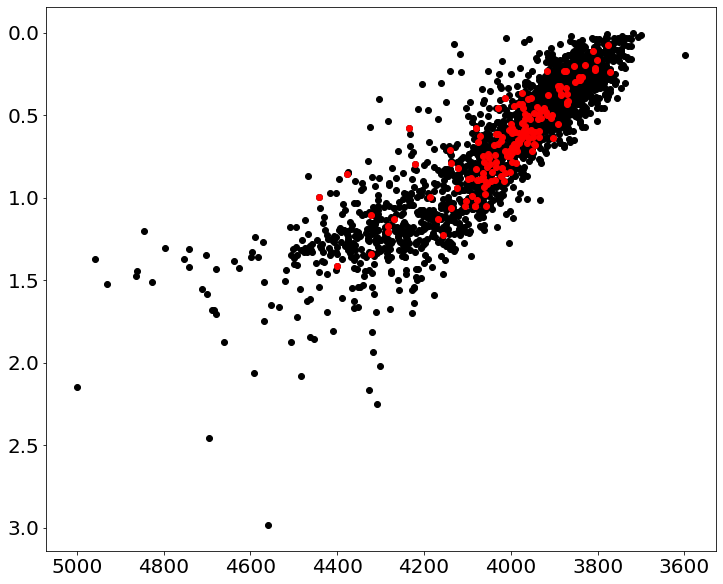

In [39]:
plt.figure(figsize=[12,10])
plt.scatter(r13['TEFF'],r13['LOGG'],c='k')
plt.scatter(r13['TEFF'][np.where(r13['FIELD']=='LMC15')],r13['LOGG'][np.where(r13['FIELD']=='LMC15')],c='r')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()



<font size='20'>
    <b>
        Binned Metallicity
    </b>
</font>

In [40]:
# ## Metallicity histogram with bins
# plt.figure(figsize=[12,10])
# plt.hist(r13['FE_H'],bins=20)
# plt.axvline(-1.0,c='k')
# plt.axvline(-0.5,c='k')
# # plt.text(-1.75,1150,'MP: {}'.format(len(np.squeeze(np.where(r13['FE_H']<-1.0)))))
# # plt.text(-0.9,1150,'MInt: {}'.format(len(np.squeeze(np.where((r13['FE_H']<-0.5)&(r13['FE_H']>-1.0))))))
# # plt.text(-0.4,1150,'MR: {}'.format(len(np.squeeze(np.where(r13['FE_H']>-0.5)))))
# plt.show()

# ## Metallicity as function of radius
# plt.figure(figsize=[12,10])
# plt.scatter(np.sqrt(xLMC**2+yLMC**2),r13['FE_H'],marker='+',c='tab:blue')
# plt.axhline(-0.5,c='k',lw=2.5)
# plt.axhline(-1.0,c='k',lw=2.5)

# plt.title(r'[Fe/H] Radial Bins Spatial Extent',fontsize=20)

# plt.xlabel(r'Radius (kpc)',fontsize=20)
# plt.ylabel(r'[Fe/H]',fontsize=20)

# plt.text(7.25,-0.45,'MR',fontsize=20)
# plt.text(7.25,-0.95,'MInt',fontsize=20)
# plt.text(7.25,-2.25,'MP',fontsize=20)
# plt.show()

# ## Bin by metallicity
# mp = np.where(r13['FE_H']<-1.0)
# mint = np.where((r13['FE_H']>=-1.0)&(r13['FE_H']<-0.5))
# mr = np.where(r13['FE_H']>=-0.5)

# #Metal Poor
# mpr13 = bloopr13[mp]
# mpages = bloopage[mp]
# mpabsH = bloopabsH[mp]

# #Metal Intermediate 
# mintr13 = bloopr13[mint]
# mintages = bloopage[mint]
# mintabsH = bloopabsH[mint]

# #Metal Rich
# mrr13 = bloopr13[mr]
# mrages = bloopage[mr]
# mrabsH = bloopabsH[mr]

### Second Bin scheme

In [41]:
metal_poor = np.where(bloopr13['FE_H']<-0.87833154)
m_int1 = np.where((bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
m_int2 = np.where((bloopr13['FE_H']>=-0.7067915)&(bloopr13['FE_H']<-0.5933316))
metal_rich = np.where(bloopr13['FE_H']>=-0.5933316)

#Metal Poor
mpr13 = bloopr13[metal_poor]
mpages = bloopage[metal_poor]
mpabsH = bloopabsH[metal_poor]

#Metal Intermediate 1
mint1r13 = bloopr13[m_int1]
mint1ages = bloopage[m_int1]
mint1absH = bloopabsH[m_int1]

#Metal Intermediate 2
mint2r13 = bloopr13[m_int2]
mint2ages = bloopage[m_int2]
mint2absH = bloopabsH[m_int2]

#Metal Rich
mrr13 = bloopr13[metal_rich]
mrages = bloopage[metal_rich]
mrabsH = bloopabsH[metal_rich]

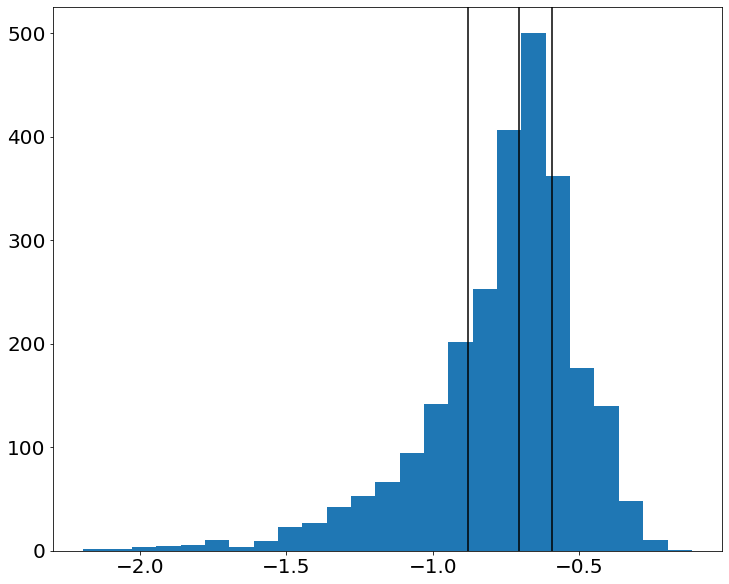

Text(7.05, -2.25, 'MP')

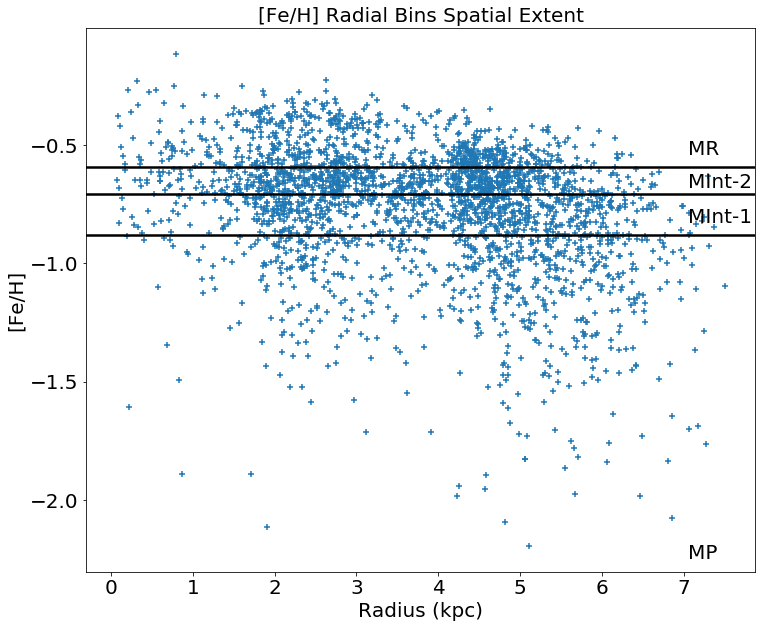

In [42]:
## Metallicity histogram with bins
plt.figure(figsize=[12,10])
plt.hist(r13['FE_H'],bins=25)
plt.axvline(-0.87833154,c='k')
plt.axvline(-0.7067915,c='k')
plt.axvline(-0.5933316,c='k')
# plt.text(-1.75,1150,'MP: {}'.format(len(np.squeeze(np.where(r13['FE_H']<-1.0)))))
# plt.text(-0.9,1150,'MInt: {}'.format(len(np.squeeze(np.where((r13['FE_H']<-0.5)&(r13['FE_H']>-1.0))))))
# plt.text(-0.4,1150,'MR: {}'.format(len(np.squeeze(np.where(r13['FE_H']>-0.5)))))
plt.show()

## Metallicity as function of radius
plt.figure(figsize=[12,10])
plt.scatter(np.sqrt(xLMC**2+yLMC**2),r13['FE_H'],marker='+',c='tab:blue')
# plt.axhline(-0.5,c='k',lw=2.5)
# plt.axhline(-1.0,c='k',lw=2.5)
plt.axhline(-0.87833154,c='k',lw=2.5)
plt.axhline(-0.7067915,c='k',lw=2.5)
plt.axhline(-0.5933316,c='k',lw=2.5)

plt.title(r'[Fe/H] Radial Bins Spatial Extent',fontsize=20)

plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'[Fe/H]',fontsize=20)

plt.text(7.05,-0.5933316+0.05,'MR',fontsize=20)
plt.text(7.05,-0.7067915+0.025,'MInt-2',fontsize=20)
plt.text(7.05,-0.87833154+0.05,'MInt-1',fontsize=20)
plt.text(7.05,-2.25,'MP',fontsize=20)
# plt.show()

## Metal Poor

In [43]:
mp_iso_ages = []
mp_iso_zs = []

#fnt and brt bins
mp_fbins = dfunc.brtfntlmc_bins(mpr13)

for i in range(len(field_str)):
    fd = np.where(mpr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mpages[fd]),np.median(mpr13[fd]['FE_H']))
    mp_iso_ages.append(age)
    mp_iso_zs.append(z)

mp_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mpr13['FIELD']==field_str[i]) 
    mp_absHs.append(np.asarray(mpabsH)[field_H])

# mp_sf_brites = []
# mp_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(mp_fbins))[1::2]:
#         mp_sf_brites.append(mpr13[mp_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(mp_fbins))[0::2]:
#         mp_sf_faints.append(mpr13[mp_fbins[j]]['SELECTFUNC'])

mp_sf_brites = []
mp_sf_faints = []

for i in field_str:
    fld = np.where(mpr13['FIELD']==i)
    
    fnts = np.where(mpr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mpr13['TARGET_NAME'][fld]=='BrtRGB')
    
    mp_sf_faints.append(mpr13['SELECTFUNC'][fld][fnts])
    mp_sf_brites.append(mpr13['SELECTFUNC'][fld][brts])
        
mp_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mp_field_masses.append(dfunc.fieldmass(mp_iso_ages[i],mp_iso_zs[i],mp_absHs[i],mp_sf_brites[i],
                                               mp_sf_faints[i],parsec))
    except:
        mp_field_masses.append(-9999.0)
        
for i in range(len(mp_field_masses)):
    if np.isfinite(mp_field_masses[i]) == False:
        mp_field_masses[i] = -9999.0

In [44]:
mp_field_masses

[-9999.0,
 1504532.2761609673,
 1393264.4873126578,
 2920823.174837127,
 3936249.871320137,
 18406594.905885253,
 10617092.052957999,
 4783366.783001381,
 12215610.841002597,
 59167602.31726517,
 2091833.3916599855,
 5814033.024952444,
 1046363.6860482243,
 10747974.154954005,
 21028468.084006328,
 2974877.4146886724,
 1456350.6053616263,
 5243800.50667527]

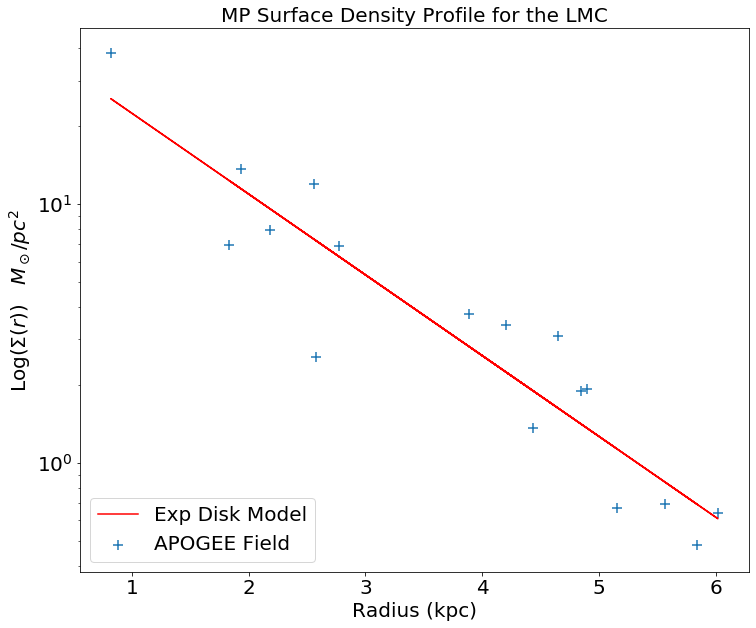

In [45]:
mp_surfden = []
for i in range(len(mp_field_masses)):
    mp_surfden.append(np.divide(mp_field_masses[i],field_areas[i]))

field_list = [np.where(mpr13['FIELD']=='30Dor'),np.where(mpr13['FIELD']=='LMC1'),
              np.where(mpr13['FIELD']=='LMC2'),np.where(mpr13['FIELD']=='LMC3'),
              np.where(mpr13['FIELD']=='LMC4'),np.where(mpr13['FIELD']=='LMC5'),
              np.where(mpr13['FIELD']=='LMC6'),np.where(mpr13['FIELD']=='LMC7'),
              np.where(mpr13['FIELD']=='LMC8'),np.where(mpr13['FIELD']=='LMC9'),
              np.where(mpr13['FIELD']=='LMC10'),np.where(mpr13['FIELD']=='LMC11'),
              np.where(mpr13['FIELD']=='LMC12'),np.where(mpr13['FIELD']=='LMC13'),
              np.where(mpr13['FIELD']=='LMC14'),np.where(mpr13['FIELD']=='LMC15'),
              np.where(mpr13['FIELD']=='LMC16'),np.where(mpr13['FIELD']=='LMC17')]

mp_radii = []

# for i in range(len(field_str)):
#     mp_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mpr13['RA'][field_list[i]],
#                                                          mpr13['DEC'][field_list[i]])[0])**2 + 
#                             np.median(dfunc.LMCdisk_cart(mpr13['RA'][field_list[i]],
#                                                          mpr13['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(mpr13['RA'],mpr13['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    mp_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(mp_surfden)>0.0)

mp_radii = np.asarray(mp_radii)[good]
mp_surfden = np.asarray(mp_surfden)[good]


mp_b, mp_m,mp_err = ols_fit(mp_radii,np.log(mp_surfden))

def mpprofile(r):
    return mp_m+np.multiply(mp_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(mp_radii,mp_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(mp_radii)):
#     plt.text(mp_radii[i],mp_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('MP Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mpprofile.pdf',bbox_inches='tight')
plt.show()

## Metal Intermediate 1

In [46]:
mint1_iso_ages = []
mint1_iso_zs = []

#fnt and brt bins
mint1_fbins = dfunc.brtfntlmc_bins(mint1r13)

for i in range(len(field_str)):
    fd = np.where(mint1r13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mint1ages[fd]),np.median(mint1r13[fd]['FE_H']))
    mint1_iso_ages.append(age)
    mint1_iso_zs.append(z)

mint1_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mint1r13['FIELD']==field_str[i]) 
    mint1_absHs.append(np.asarray(mint1absH)[field_H])

# mint1_sf_brites = []
# mint1_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(mint1_fbins))[1::2]:
#         mint1_sf_brites.append(mint1r13[mint1_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(mint1_fbins))[0::2]:
#         mint1_sf_faints.append(mint1r13[mint1_fbins[j]]['SELECTFUNC'])

mint1_sf_brites = []
mint1_sf_faints = []

for i in field_str:
    fld = np.where(mint1r13['FIELD']==i)
    
    fnts = np.where(mint1r13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mint1r13['TARGET_NAME'][fld]=='BrtRGB')
    
    mint1_sf_faints.append(mint1r13['SELECTFUNC'][fld][fnts])
    mint1_sf_brites.append(mint1r13['SELECTFUNC'][fld][brts])
        
mint1_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mint1_field_masses.append(dfunc.fieldmass(mint1_iso_ages[i],mint1_iso_zs[i],mint1_absHs[i],mint1_sf_brites[i],
                                               mint1_sf_faints[i],parsec))
    except:
        mint1_field_masses.append(-9999.0)
        
for i in range(len(mint1_field_masses)):
    if np.isfinite(mint1_field_masses[i]) == False:
        mint1_field_masses[i] = -9999.0

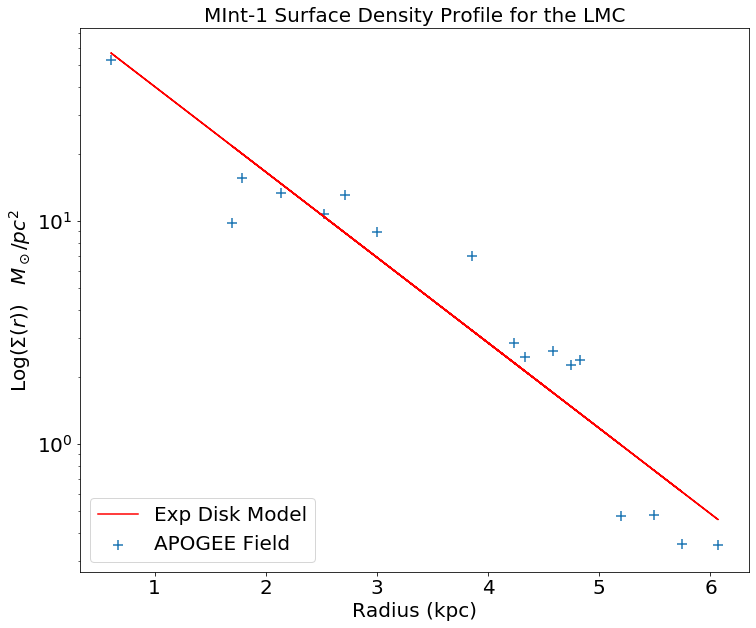

In [47]:
mint1_surfden = []
for i in range(len(mint1_field_masses)):
    mint1_surfden.append(np.divide(mint1_field_masses[i],field_areas[i]))

field_list = [np.where(mint1r13['FIELD']=='30Dor'),np.where(mint1r13['FIELD']=='LMC1'),
              np.where(mint1r13['FIELD']=='LMC2'),np.where(mint1r13['FIELD']=='LMC3'),
              np.where(mint1r13['FIELD']=='LMC4'),np.where(mint1r13['FIELD']=='LMC5'),
              np.where(mint1r13['FIELD']=='LMC6'),np.where(mint1r13['FIELD']=='LMC7'),
              np.where(mint1r13['FIELD']=='LMC8'),np.where(mint1r13['FIELD']=='LMC9'),
              np.where(mint1r13['FIELD']=='LMC10'),np.where(mint1r13['FIELD']=='LMC11'),
              np.where(mint1r13['FIELD']=='LMC12'),np.where(mint1r13['FIELD']=='LMC13'),
              np.where(mint1r13['FIELD']=='LMC14'),np.where(mint1r13['FIELD']=='LMC15'),
              np.where(mint1r13['FIELD']=='LMC16'),np.where(mint1r13['FIELD']=='LMC17')]

mint1_radii = []

# for i in range(len(field_str)):
#     mint1_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mint1r13['RA'][field_list[i]],
#                                                             mint1r13['DEC'][field_list[i]])[0])**2 + 
#                                np.median(dfunc.LMCdisk_cart(mint1r13['RA'][field_list[i]],
#                                                             mint1r13['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(mint1r13['RA'],mint1r13['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    mint1_radii.append(np.median(ell[field_list[i]]))
    

good = np.where(np.asarray(mint1_surfden)>0.0)
mint1_radii = np.delete(np.asarray(mint1_radii),0)
mint1_surfden = np.delete(np.asarray(mint1_surfden)[good],0)


# mint1_radii = mint1_radii[good]
# mint1_surfden = mint1_surfden[good]


mint1_b, mint1_m,mint1_err = ols_fit(mint1_radii,np.log(mint1_surfden))

def mint1profile(r):
    return mint1_m+np.multiply(mint1_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(mint1_radii,mint1_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(mint1_radii)):
#     plt.text(mint1_radii[i],mint1_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(mint1_radii,np.exp(mint1profile(mint1_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('MInt-1 Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mint1profile.pdf',bbox_inches='tight')
plt.show()

# Metal Intermediate 2

In [48]:
mint2_iso_ages = []
mint2_iso_zs = []

#fnt and brt bins
mint2_fbins = dfunc.brtfntlmc_bins(mint2r13)

for i in range(len(field_str)):
    fd = np.where(mint2r13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mint2ages[fd]),np.median(mint2r13[fd]['FE_H']))
    mint2_iso_ages.append(age)
    mint2_iso_zs.append(z)

mint2_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mint2r13['FIELD']==field_str[i]) 
    mint2_absHs.append(np.asarray(mint2absH)[field_H])

# mint2_sf_brites = []
# mint2_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(mint2_fbins))[1::2]:
#         mint2_sf_brites.append(mint2r13[mint2_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(mint2_fbins))[0::2]:
#         mint2_sf_faints.append(mint2r13[mint2_fbins[j]]['SELECTFUNC'])

mint2_sf_brites = []
mint2_sf_faints = []

for i in field_str:
    fld = np.where(mint2r13['FIELD']==i)
    
    fnts = np.where(mint2r13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mint2r13['TARGET_NAME'][fld]=='BrtRGB')
    
    mint2_sf_faints.append(mint2r13['SELECTFUNC'][fld][fnts])
    mint2_sf_brites.append(mint2r13['SELECTFUNC'][fld][brts])
        
mint2_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mint2_field_masses.append(dfunc.fieldmass(mint2_iso_ages[i],mint2_iso_zs[i],mint2_absHs[i],mint2_sf_brites[i],
                                               mint2_sf_faints[i],parsec))
    except:
        mint2_field_masses.append(-9999.0)
        
for i in range(len(mint2_field_masses)):
    if np.isfinite(mint2_field_masses[i]) == False:
        mint2_field_masses[i] = -9999.0

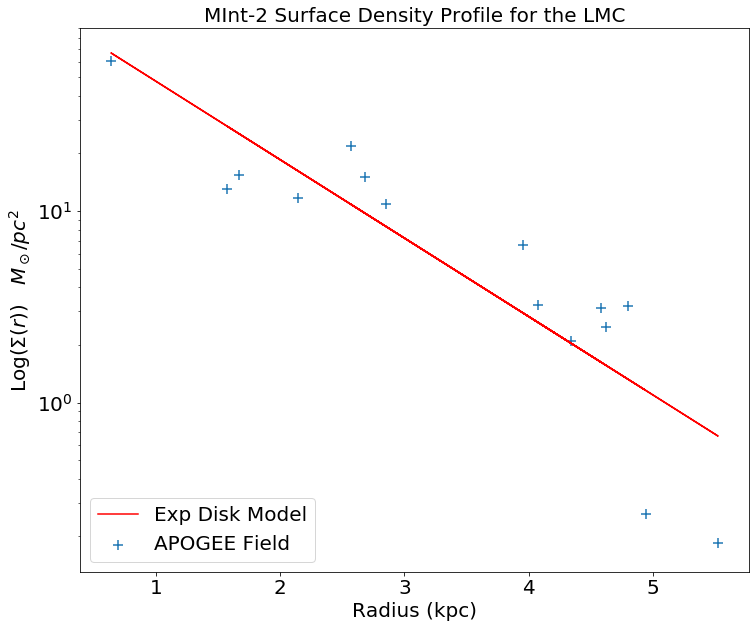

In [49]:
mint2_surfden = []
for i in range(len(mint2_field_masses)):
    mint2_surfden.append(np.divide(mint2_field_masses[i],field_areas[i]))

field_list = [np.where(mint2r13['FIELD']=='30Dor'),np.where(mint2r13['FIELD']=='LMC1'),
              np.where(mint2r13['FIELD']=='LMC2'),np.where(mint2r13['FIELD']=='LMC3'),
              np.where(mint2r13['FIELD']=='LMC4'),np.where(mint2r13['FIELD']=='LMC5'),
              np.where(mint2r13['FIELD']=='LMC6'),np.where(mint2r13['FIELD']=='LMC7'),
              np.where(mint2r13['FIELD']=='LMC8'),np.where(mint2r13['FIELD']=='LMC9'),
              np.where(mint2r13['FIELD']=='LMC10'),np.where(mint2r13['FIELD']=='LMC11'),
              np.where(mint2r13['FIELD']=='LMC12'),np.where(mint2r13['FIELD']=='LMC13'),
              np.where(mint2r13['FIELD']=='LMC14'),np.where(mint2r13['FIELD']=='LMC15'),
              np.where(mint2r13['FIELD']=='LMC16'),np.where(mint2r13['FIELD']=='LMC17')]

mint2_radii = []

# for i in range(len(field_str)):
#     mint2_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mint2r13['RA'][field_list[i]],
#                                                             mint2r13['DEC'][field_list[i]])[0])**2 + 
#                                np.median(dfunc.LMCdisk_cart(mint2r13['RA'][field_list[i]],
#                                                             mint2r13['DEC'][field_list[i]])[1])**2))
    
x, y, _ = dfunc.LMCdisk_cart(mint2r13['RA'],mint2r13['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    mint2_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(mint2_surfden)>0.0)

mint2_radii = np.delete(np.asarray(mint2_radii)[good],0)
mint2_surfden = np.delete(np.asarray(mint2_surfden)[good],0)


mint2_b, mint2_m, mint2_err = ols_fit(mint2_radii,np.log(mint2_surfden))

def mint2profile(r):
    return mint2_m+np.multiply(mint2_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17'] #'30Dor',
#rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(mint2_radii,mint2_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(mint2_radii)):
#     plt.text(mint2_radii[i],mint2_surfden[i])
plt.plot(mint2_radii,np.exp(mint2profile(mint2_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('MInt-2 Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mint2profile.pdf',bbox_inches='tight')
plt.show()

## Metal Rich

In [50]:
mr_iso_ages = []
mr_iso_zs = []

#fnt and brt bins
mr_fbins = dfunc.brtfntlmc_bins(mrr13)

for i in range(len(field_str)):
    fd = np.where(mrr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mrages[fd]),np.median(mrr13[fd]['FE_H']))
    mr_iso_ages.append(age)
    mr_iso_zs.append(z)

mr_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mrr13['FIELD']==field_str[i]) 
    mr_absHs.append(np.asarray(mrabsH)[field_H])

# mr_sf_brites = []
# mr_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(mr_fbins))[1::2]:
#         mr_sf_brites.append(mrr13[mr_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(mr_fbins))[0::2]:
#         mr_sf_faints.append(mrr13[mr_fbins[j]]['SELECTFUNC'])

mr_sf_brites = []
mr_sf_faints = []

for i in field_str:
    fld = np.where(mrr13['FIELD']==i)
    
    fnts = np.where(mrr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mrr13['TARGET_NAME'][fld]=='BrtRGB')
    
    mr_sf_faints.append(mrr13['SELECTFUNC'][fld][fnts])
    mr_sf_brites.append(mrr13['SELECTFUNC'][fld][brts])
        
mr_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mr_field_masses.append(dfunc.fieldmass(mr_iso_ages[i],mr_iso_zs[i],mr_absHs[i],mr_sf_brites[i],
                                               mr_sf_faints[i],parsec))
    except:
        mr_field_masses.append(-9999.0)
        
for i in range(len(mr_field_masses)):
    if np.isfinite(mr_field_masses[i]) == False:
        mr_field_masses[i] = -9999.0

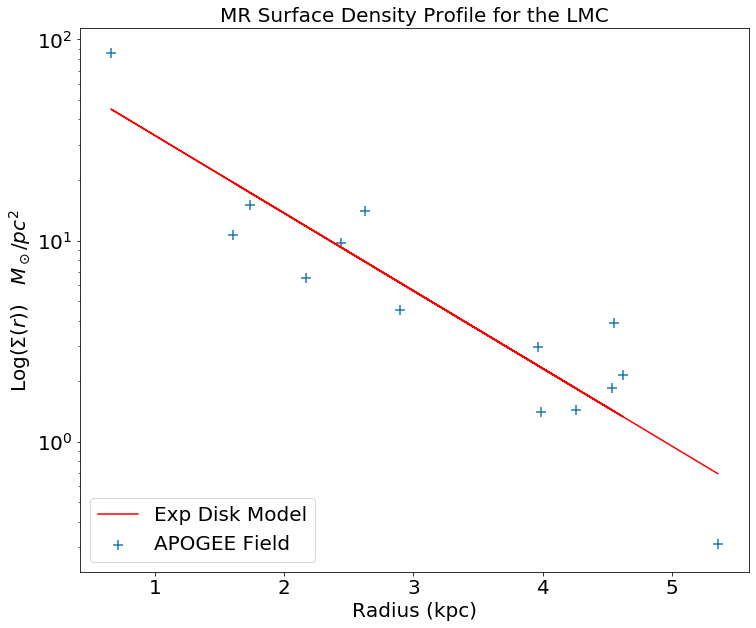

In [51]:
mr_surfden = []
for i in range(len(mr_field_masses)):
    mr_surfden.append(np.divide(mr_field_masses[i],field_areas[i]))

field_list = [np.where(mrr13['FIELD']=='30Dor'),np.where(mrr13['FIELD']=='LMC1'),
              np.where(mrr13['FIELD']=='LMC2'),np.where(mrr13['FIELD']=='LMC3'),
              np.where(mrr13['FIELD']=='LMC4'),np.where(mrr13['FIELD']=='LMC5'),
              np.where(mrr13['FIELD']=='LMC6'),np.where(mrr13['FIELD']=='LMC7'),
              np.where(mrr13['FIELD']=='LMC8'),np.where(mrr13['FIELD']=='LMC9'),
              np.where(mrr13['FIELD']=='LMC10'),np.where(mrr13['FIELD']=='LMC11'),
              np.where(mrr13['FIELD']=='LMC12'),np.where(mrr13['FIELD']=='LMC13'),
              np.where(mrr13['FIELD']=='LMC14'),np.where(mrr13['FIELD']=='LMC15'),
              np.where(mrr13['FIELD']=='LMC16'),np.where(mrr13['FIELD']=='LMC17')]

mr_radii = []

# for i in range(len(field_str)):
#     mr_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mrr13['RA'][field_list[i]],
#                                                             mrr13['DEC'][field_list[i]])[0])**2 + 
#                                np.median(dfunc.LMCdisk_cart(mrr13['RA'][field_list[i]],
#                                                             mrr13['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(mrr13['RA'],mrr13['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    mr_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(mr_surfden)>0.0)

mr_radii = np.delete(np.asarray(mr_radii)[good],0)
mr_surfden = np.delete(np.asarray(mr_surfden)[good],0)


mr_b, mr_m, mr_err = ols_fit(mr_radii,np.log(mr_surfden))

def mrprofile(r):
    return mr_m+np.multiply(mr_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17'] #'30Dor',
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(mr_radii,mr_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(mr_radii)):
#     plt.text(mr_radii[i],mr_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('MR Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mrprofile.pdf',bbox_inches='tight')
plt.show()

## Plot All Profiles

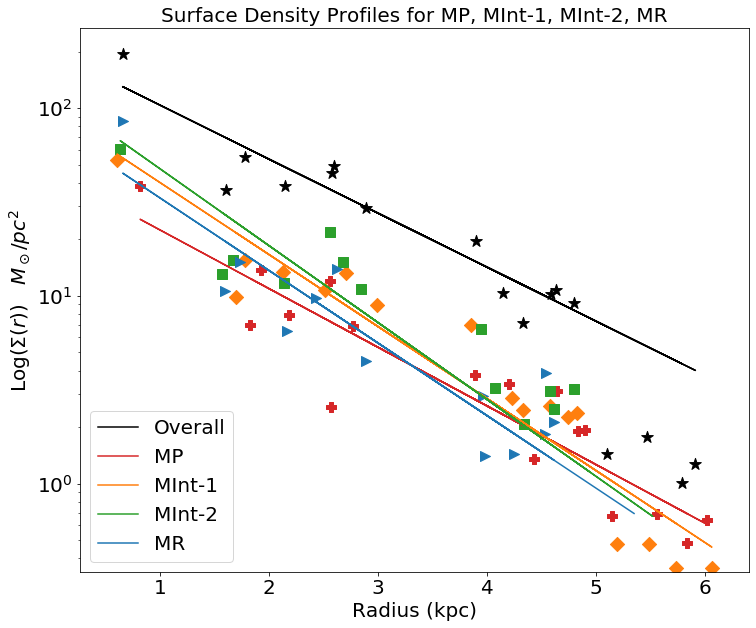

central: 46.106
scale: 1.391
err: 0.143
central: 97.138
scale: 1.133
err: 0.094
central: 122.133
scale: 1.061
err: 0.157
central: 80.986
scale: 1.125
err: 0.142


In [52]:
plt.figure(figsize=[12,10])

plt.plot(radii,np.exp(lmcdensityprofile(radii)),c='k',label='Overall')
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='tab:red',label='MP')
plt.plot(mint1_radii,np.exp(mint1profile(mint1_radii)),c='tab:orange',label='MInt-1')
plt.plot(mint2_radii,np.exp(mint2profile(mint2_radii)),c='tab:green',label='MInt-2')
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='tab:blue',label='MR')

plt.legend(loc='lower left',fontsize=20)

plt.scatter(radii_rm30dor,surfden_rm30dor,marker='*',c='k',s=150)
plt.scatter(mp_radii,mp_surfden,marker='P',c='tab:red',s=100)
plt.scatter(mint1_radii,mint1_surfden,marker='D',c='tab:orange',s=100)
plt.scatter(mint2_radii,mint2_surfden,marker='s',c='tab:green',s=100)
plt.scatter(mr_radii,mr_surfden,marker='>',c='tab:blue',s=100)

# plt.ylim(bottom=1)

plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profiles for MP, MInt-1, MInt-2, MR',fontsize=20)

plt.savefig('allprofiles',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(mp_m)))
print('scale: {:.3f}'.format(-np.reciprocal(mp_b)))
print('err: {:.3f}'.format(mp_err[0]/(mp_b)**2))

print('central: {:.3f}'.format(np.exp(mint1_m)))
print('scale: {:.3f}'.format(-np.reciprocal(mint1_b)))
print('err: {:.3f}'.format(mint1_err[0]/(mint1_b)**2))

print('central: {:.3f}'.format(np.exp(mint2_m)))
print('scale: {:.3f}'.format(-np.reciprocal(mint2_b)))
print('err: {:.3f}'.format(mint2_err[0]/(mint2_b)**2))

print('central: {:.3f}'.format(np.exp(mr_m)))
print('scale: {:.3f}'.format(-np.reciprocal(mr_b)))
print('err: {:.3f}'.format(mr_err[0]/(mr_b)**2))

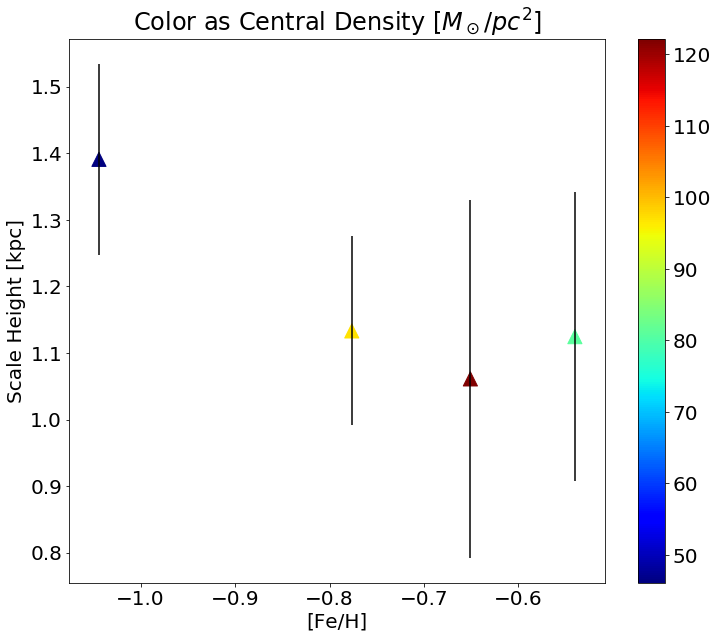

In [53]:
medage = [np.median(bloopr13[metal_poor]['FE_H']),np.median(bloopr13[m_int1]['FE_H']),
          np.median(bloopr13[m_int2]['FE_H']),np.median(bloopr13[metal_rich]['FE_H']),]

heights = [-np.reciprocal(mp_b),-np.reciprocal(mint1_b),-np.reciprocal(mint2_b),-np.reciprocal(mr_b)]

heights_err = [mp_err[0]/(mp_b)**2,mint1_err[0]/(mp_b)**2,mint2_err[0]/(mp_b)**2,mr_err[0]/(mp_b)**2]

cen_den = [np.exp(mp_m),np.exp(mint1_m),np.exp(mint2_m),np.exp(mr_m)]

plt.figure(figsize=[12,10])
plt.errorbar(medage,heights,yerr=heights_err,c='k',ls='none')
plt.scatter(medage,heights,marker='^',s=200,c=cen_den,cmap='jet')
plt.colorbar()
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Scale Height [kpc]')
plt.title(r'Color as Central Density [$M_\odot/pc^2$]')
plt.savefig('feh_scale.png',bbox_inches='tight')
plt.show()

<font size='48'>
    <b>
        Metal Poor All Ages
    </b>
<font>

In [54]:
mp_young = np.where((bloopr13['FE_H']<-0.87833154)&(bloopage<0.5))
mp_yless = np.where((bloopr13['FE_H']<-0.87833154)&(bloopage>0.5)&(bloopage<=2.0))
mp_ymed = np.where((bloopr13['FE_H']<-0.87833154)&(bloopage>2.0)&(bloopage<=7.0))
mp_omed = np.where((bloopr13['FE_H']<-0.87833154)&(bloopage>7.0)&(bloopage<=10.5))
mp_old = np.where((bloopr13['FE_H']<-0.87833154)&(bloopage>10.5))

# print(mp_young)
# print(mp_yless)
# print(mp_ymed)
# print(mp_omed)
# print(mp_old)


# m_int1 = np.where((bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
# m_int2 = np.where((bloopr13['FE_H']>=-0.7067915)&(bloopr13['FE_H']<-0.5933316))
# metal_rich = np.where(bloopr13['FE_H']>=-0.5933316)

# Metal Poor ymed
mpymedr13 = bloopr13[mp_ymed]
mpymedages = bloopage[mp_ymed]
mpymedabsH = bloopabsH[mp_ymed]

# Metal Poor ymed
mpomedr13 = bloopr13[mp_omed]
mpomedages = bloopage[mp_omed]
mpomedabsH = bloopabsH[mp_omed]

# Metal Poor ymed
mpoldr13 = bloopr13[mp_old]
mpoldages = bloopage[mp_old]
mpoldabsH = bloopabsH[mp_old]

# Ages

In [55]:
mpomed_iso_ages = []
mpomed_iso_zs = []

#fnt and brt bins
mpomed_fbins = dfunc.brtfntlmc_bins(mpomedr13)

for i in range(len(field_str)):
    fd = np.where(mpomedr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mpomedages[fd]),np.median(mpomedr13[fd]['FE_H']))
    mpomed_iso_ages.append(age)
    mpomed_iso_zs.append(z)

mpomed_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mpomedr13['FIELD']==field_str[i]) 
    mpomed_absHs.append(np.asarray(mpomedabsH)[field_H])

mpomed_sf_brites = []
mpomed_sf_faints = []
for i,j in enumerate(fbins):
    if i in np.arange(len(mpomed_fbins))[1::2]:
        mpomed_sf_brites.append(mpomedr13[mpomed_fbins[j]]['SELECTFUNC'])
    if i in np.arange(len(mpomed_fbins))[0::2]:
        mpomed_sf_faints.append(mpomedr13[mpomed_fbins[j]]['SELECTFUNC'])
        
mpomed_field_masses = []
for i in range(len(field_str)):
    try:
        mpomed_field_masses.append(dfunc.fieldmass(mpomed_iso_ages[i],mpomed_iso_zs[i],mpomed_absHs[i],
                                                   mpomed_sf_brites[i],mpomed_sf_faints[i],parsec))
    except:
        mpomed_field_masses.append(-9999.0)
        
for i in range(len(mpomed_field_masses)):
    if np.isfinite(mpomed_field_masses[i]) == False:
        mpomed_field_masses[i] = -9999.0

In [56]:
# mpomed_fbins


print(mpomed_iso_ages[1])
print(mpomed_iso_zs[1])
print(max(mpomed_absHs[1]))
print(min(mpomed_absHs[1]))
print(mpomed_sf_brites[1])
print(mpomed_sf_faints[1])
# print(mpomed_absHs[2])

10.05
0.0018702
-4.329047935360418
-6.325175121914249
[2.0466666 2.2931035 2.0466666 2.0466666 2.0466666]
[2.691057  2.691057  2.691057  2.691057  2.691057  2.691057  2.691057
 2.691057  2.691057  2.691057  2.691057  2.691057  2.691057  2.691057
 2.691057  2.691057  2.691057  4.4905663 4.4905663 4.4905663 4.4905663
 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663
 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663
 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663 4.4905663
 2.3605769 2.3605769 2.3605769 2.3605769 2.3605769 2.3605769 2.3605769]


In [57]:
mpomed_field_masses

[-9999.0,
 2611135.215613197,
 2140390.3778947764,
 2679866.708041156,
 3280208.226100114,
 15395927.607053721,
 9069412.452051898,
 4214398.015310467,
 9016284.192168582,
 54616248.29286016,
 2165014.959977545,
 5499837.4447793495,
 1487370.680835542,
 10150864.479678782,
 19387690.017391823,
 33511322.66861104,
 1988049.465575049,
 7225816.761318737]

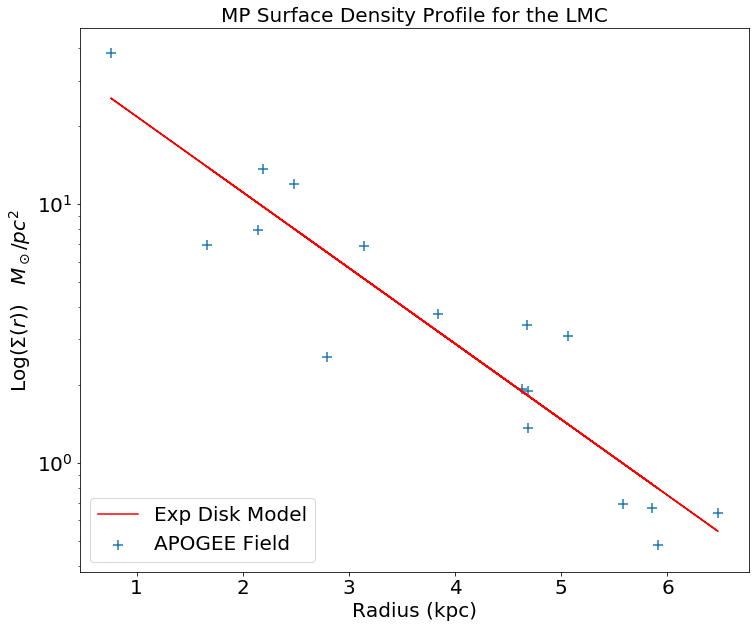

In [58]:
mp_surfden = []
for i in range(len(mp_field_masses)):
    mp_surfden.append(np.divide(mp_field_masses[i],field_areas[i]))

field_list = [np.where(mpr13['FIELD']=='30Dor'),np.where(mpr13['FIELD']=='LMC1'),
              np.where(mpr13['FIELD']=='LMC2'),np.where(mpr13['FIELD']=='LMC3'),
              np.where(mpr13['FIELD']=='LMC4'),np.where(mpr13['FIELD']=='LMC5'),
              np.where(mpr13['FIELD']=='LMC6'),np.where(mpr13['FIELD']=='LMC7'),
              np.where(mpr13['FIELD']=='LMC8'),np.where(mpr13['FIELD']=='LMC9'),
              np.where(mpr13['FIELD']=='LMC10'),np.where(mpr13['FIELD']=='LMC11'),
              np.where(mpr13['FIELD']=='LMC12'),np.where(mpr13['FIELD']=='LMC13'),
              np.where(mpr13['FIELD']=='LMC14'),np.where(mpr13['FIELD']=='LMC15'),
              np.where(mpr13['FIELD']=='LMC16'),np.where(mpr13['FIELD']=='LMC17')]

mp_radii = []

for i in range(len(field_str)):
    mp_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mpr13['RA'][field_list[i]],
                                                         mpr13['DEC'][field_list[i]])[0])**2 + 
                            np.median(dfunc.LMCdisk_cart(mpr13['RA'][field_list[i]],
                                                         mpr13['DEC'][field_list[i]])[1])**2))
    
good = np.where(np.asarray(mp_surfden)>0.0)

mp_radii = np.asarray(mp_radii)[good]
mp_surfden = np.asarray(mp_surfden)[good]


mp_b, mp_m, mp_err = ols_fit(mp_radii,np.log(mp_surfden))

def mpprofile(r):
    return mp_m+np.multiply(mp_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(mp_radii,mp_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(mp_radii)):
#     plt.text(mp_radii[i],mp_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('MP Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mpprofile.pdf',bbox_inches='tight')
plt.show()

In [59]:
young_field_masses

NameError: name 'young_field_masses' is not defined

# young stars

In [63]:
young_iso_ages = []
young_iso_zs = []

#fnt and brt bins
young_fbins = dfunc.brtfntlmc_bins(r13young)

for i in range(len(field_str)):
    fd = np.where(r13young['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(parage[young][fd]),np.median(r13young[fd]['FE_H']))
    young_iso_ages.append(age)
    young_iso_zs.append(z)

young_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13young['FIELD']==field_str[i]) 
    young_absHs.append(np.asarray(bloopabsH[young])[field_H])

young_sf_brites = []
young_sf_faints = []

for i in field_str:
    fld = np.where(r13young['FIELD']==i)
    
    fnts = np.where(r13young['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13young['TARGET_NAME'][fld]=='BrtRGB')
    
    young_sf_faints.append(r13young['SELECTFUNC'][fld][fnts])
    young_sf_brites.append(r13young['SELECTFUNC'][fld][brts])
        
young_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        young_field_masses.append(dfunc.fieldmass(young_iso_ages[i],young_iso_zs[i],young_absHs[i],young_sf_brites[i],
                                               young_sf_faints[i],parsec))
    except:
        young_field_masses.append(-9999.0)
        
for i in range(len(young_field_masses)):
    if np.isfinite(young_field_masses[i]) == False:
        young_field_masses[i] = -9999.0

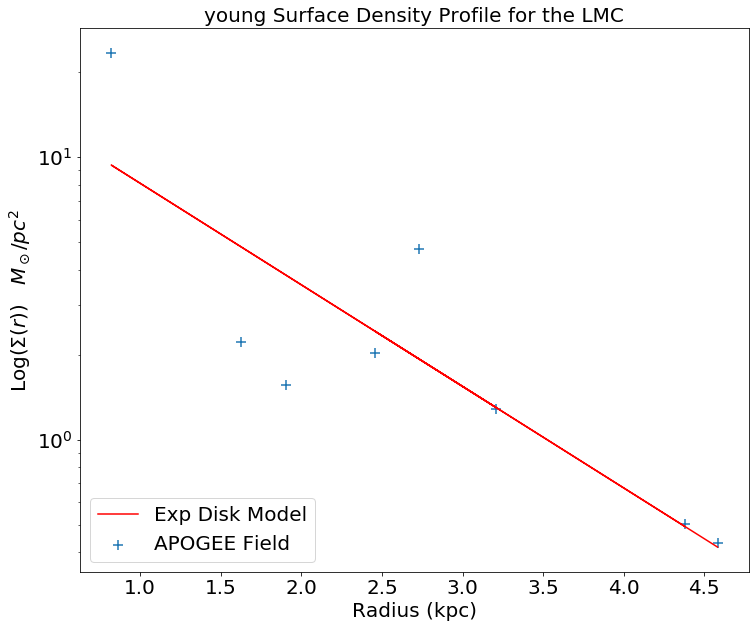

central: 18.531
scale: 1.207
err: 0.301


In [64]:
young_surfden = []
for i in range(len(young_field_masses)):
    young_surfden.append(np.divide(young_field_masses[i],field_areas[i]))

field_list = [np.where(r13young['FIELD']=='30Dor'),np.where(r13young['FIELD']=='LMC1'),
              np.where(r13young['FIELD']=='LMC2'),np.where(r13young['FIELD']=='LMC3'),
              np.where(r13young['FIELD']=='LMC4'),np.where(r13young['FIELD']=='LMC5'),
              np.where(r13young['FIELD']=='LMC6'),np.where(r13young['FIELD']=='LMC7'),
              np.where(r13young['FIELD']=='LMC8'),np.where(r13young['FIELD']=='LMC9'),
              np.where(r13young['FIELD']=='LMC10'),np.where(r13young['FIELD']=='LMC11'),
              np.where(r13young['FIELD']=='LMC12'),np.where(r13young['FIELD']=='LMC13'),
              np.where(r13young['FIELD']=='LMC14'),np.where(r13young['FIELD']=='LMC15'),
              np.where(r13young['FIELD']=='LMC16'),np.where(r13young['FIELD']=='LMC17')]

young_radii = []

# for i in range(len(field_str)):
#     young_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(r13young['RA'][field_list[i]],
#                                                          r13young['DEC'][field_list[i]])[0])**2 + 
#                             np.median(dfunc.LMCdisk_cart(r13young['RA'][field_list[i]],
#                                                          r13young['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(r13young['RA'],r13young['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    young_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(young_surfden)>0.0)

young_radii = np.asarray(young_radii)[good]
young_surfden = np.asarray(young_surfden)[good]


young_b, young_m,young_err = ols_fit(young_radii,np.log(young_surfden))

def youngprofile(r):
    return young_m+np.multiply(young_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(young_radii,young_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(young_radii)):
#     plt.text(young_radii[i],young_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(young_radii,np.exp(youngprofile(young_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('young Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('youngprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(young_m)))
print('scale: {:.3f}'.format(-np.reciprocal(young_b)))
print('err: {:.3f}'.format(young_err[0]/(young_b)**2))

# yless

In [65]:
yless_iso_ages = []
yless_iso_zs = []

#fnt and brt bins
yless_fbins = dfunc.brtfntlmc_bins(r13yless)

for i in range(len(field_str)):
    fd = np.where(r13yless['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(parage[yless][fd]),np.median(r13yless[fd]['FE_H']))
    yless_iso_ages.append(age)
    yless_iso_zs.append(z)

yless_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13yless['FIELD']==field_str[i]) 
    yless_absHs.append(np.asarray(bloopabsH[yless])[field_H])

# yless_sf_brites = []
# yless_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(yless_fbins))[1::2]:
#         yless_sf_brites.append(r13yless[yless_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(yless_fbins))[0::2]:
#         yless_sf_faints.append(r13yless[yless_fbins[j]]['SELECTFUNC'])

yless_sf_brites = []
yless_sf_faints = []

for i in field_str:
    fld = np.where(r13yless['FIELD']==i)
    
    fnts = np.where(r13yless['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13yless['TARGET_NAME'][fld]=='BrtRGB')
    
    yless_sf_faints.append(r13yless['SELECTFUNC'][fld][fnts])
    yless_sf_brites.append(r13yless['SELECTFUNC'][fld][brts])
        
yless_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        yless_field_masses.append(dfunc.fieldmass(yless_iso_ages[i],yless_iso_zs[i],yless_absHs[i],yless_sf_brites[i],
                                               yless_sf_faints[i],parsec))
    except:
        yless_field_masses.append(-9999.0)
        
for i in range(len(yless_field_masses)):
    if np.isfinite(yless_field_masses[i]) == False:
        yless_field_masses[i] = -9999.0

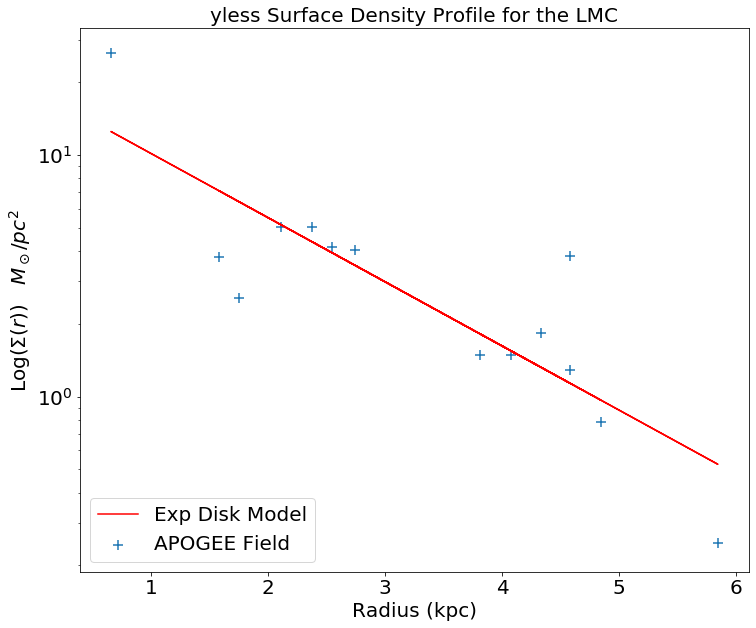

central: 18.729
scale: 1.635
err: 0.287


In [66]:
yless_surfden = []
for i in range(len(yless_field_masses)):
    yless_surfden.append(np.divide(yless_field_masses[i],field_areas[i]))

field_list = [np.where(r13yless['FIELD']=='30Dor'),np.where(r13yless['FIELD']=='LMC1'),
              np.where(r13yless['FIELD']=='LMC2'),np.where(r13yless['FIELD']=='LMC3'),
              np.where(r13yless['FIELD']=='LMC4'),np.where(r13yless['FIELD']=='LMC5'),
              np.where(r13yless['FIELD']=='LMC6'),np.where(r13yless['FIELD']=='LMC7'),
              np.where(r13yless['FIELD']=='LMC8'),np.where(r13yless['FIELD']=='LMC9'),
              np.where(r13yless['FIELD']=='LMC10'),np.where(r13yless['FIELD']=='LMC11'),
              np.where(r13yless['FIELD']=='LMC12'),np.where(r13yless['FIELD']=='LMC13'),
              np.where(r13yless['FIELD']=='LMC14'),np.where(r13yless['FIELD']=='LMC15'),
              np.where(r13yless['FIELD']=='LMC16'),np.where(r13yless['FIELD']=='LMC17')]

yless_radii = []

# for i in range(len(field_str)):
#     yless_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(r13yless['RA'][field_list[i]],
#                                                          r13yless['DEC'][field_list[i]])[0])**2 + 
#                             np.median(dfunc.LMCdisk_cart(r13yless['RA'][field_list[i]],
#                                                          r13yless['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(r13yless['RA'],r13yless['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    yless_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(yless_surfden)>0.0)

yless_radii = np.asarray(yless_radii)[good]
yless_surfden = np.asarray(yless_surfden)[good]


yless_b, yless_m,yless_err = ols_fit(yless_radii,np.log(yless_surfden))

def ylessprofile(r):
    return yless_m+np.multiply(yless_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(yless_radii,yless_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(yless_radii)):
#     plt.text(yless_radii[i],yless_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(yless_radii,np.exp(ylessprofile(yless_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('yless Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('ylessprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(yless_m)))
print('scale: {:.3f}'.format(-np.reciprocal(yless_b)))
print('err: {:.3f}'.format(yless_err[0]/(yless_b)**2))

# ymed

In [67]:
ymed_iso_ages = []
ymed_iso_zs = []

#fnt and brt bins
ymed_fbins = dfunc.brtfntlmc_bins(r13ymed)

for i in range(len(field_str)):
    fd = np.where(r13ymed['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(parage[ymed][fd]),np.median(r13ymed[fd]['FE_H']))
    ymed_iso_ages.append(age)
    ymed_iso_zs.append(z)

ymed_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13ymed['FIELD']==field_str[i]) 
    ymed_absHs.append(np.asarray(bloopabsH[ymed])[field_H])

# ymed_sf_brites = []
# ymed_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(ymed_fbins))[1::2]:
#         ymed_sf_brites.append(r13ymed[ymed_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(ymed_fbins))[0::2]:
#         ymed_sf_faints.append(r13ymed[ymed_fbins[j]]['SELECTFUNC'])

ymed_sf_brites = []
ymed_sf_faints = []

for i in field_str:
    fld = np.where(r13ymed['FIELD']==i)
    
    fnts = np.where(r13ymed['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13ymed['TARGET_NAME'][fld]=='BrtRGB')
    
    ymed_sf_faints.append(r13ymed['SELECTFUNC'][fld][fnts])
    ymed_sf_brites.append(r13ymed['SELECTFUNC'][fld][brts])
        
ymed_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        ymed_field_masses.append(dfunc.fieldmass(ymed_iso_ages[i],ymed_iso_zs[i],ymed_absHs[i],ymed_sf_brites[i],
                                               ymed_sf_faints[i],parsec))
    except:
        ymed_field_masses.append(-9999.0)
        
for i in range(len(ymed_field_masses)):
    if np.isfinite(ymed_field_masses[i]) == False:
        ymed_field_masses[i] = -9999.0

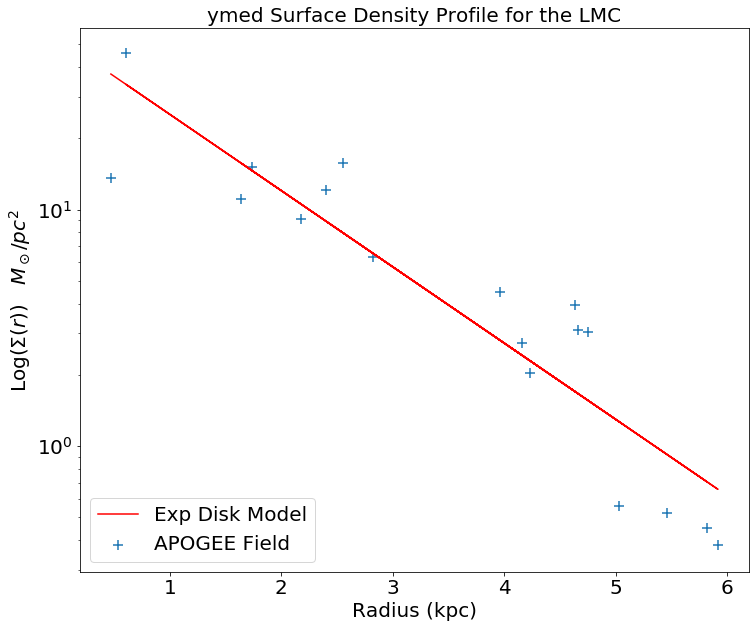

central: 53.019
scale: 1.347
err: 0.143


In [68]:
ymed_surfden = []
for i in range(len(ymed_field_masses)):
    ymed_surfden.append(np.divide(ymed_field_masses[i],field_areas[i]))

field_list = [np.where(r13ymed['FIELD']=='30Dor'),np.where(r13ymed['FIELD']=='LMC1'),
              np.where(r13ymed['FIELD']=='LMC2'),np.where(r13ymed['FIELD']=='LMC3'),
              np.where(r13ymed['FIELD']=='LMC4'),np.where(r13ymed['FIELD']=='LMC5'),
              np.where(r13ymed['FIELD']=='LMC6'),np.where(r13ymed['FIELD']=='LMC7'),
              np.where(r13ymed['FIELD']=='LMC8'),np.where(r13ymed['FIELD']=='LMC9'),
              np.where(r13ymed['FIELD']=='LMC10'),np.where(r13ymed['FIELD']=='LMC11'),
              np.where(r13ymed['FIELD']=='LMC12'),np.where(r13ymed['FIELD']=='LMC13'),
              np.where(r13ymed['FIELD']=='LMC14'),np.where(r13ymed['FIELD']=='LMC15'),
              np.where(r13ymed['FIELD']=='LMC16'),np.where(r13ymed['FIELD']=='LMC17')]

ymed_radii = []

# for i in range(len(field_str)):
#     ymed_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(r13ymed['RA'][field_list[i]],
#                                                          r13ymed['DEC'][field_list[i]])[0])**2 + 
#                             np.median(dfunc.LMCdisk_cart(r13ymed['RA'][field_list[i]],
#                                                          r13ymed['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(r13ymed['RA'],r13ymed['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    ymed_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(ymed_surfden)>0.0)

ymed_radii = np.asarray(ymed_radii)[good]
ymed_surfden = np.asarray(ymed_surfden)[good]


ymed_b, ymed_m,ymed_err = ols_fit(ymed_radii,np.log(ymed_surfden))

def ymedprofile(r):
    return ymed_m+np.multiply(ymed_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(ymed_radii,ymed_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(ymed_radii)):
#     plt.text(ymed_radii[i],ymed_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(ymed_radii,np.exp(ymedprofile(ymed_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('ymed Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('ymedprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(ymed_m)))
print('scale: {:.3f}'.format(-np.reciprocal(ymed_b)))
print('err: {:.3f}'.format(ymed_err[0]/(ymed_b)**2))

# omed

In [69]:
omed_iso_ages = []
omed_iso_zs = []

#fnt and brt bins
omed_fbins = dfunc.brtfntlmc_bins(r13omed)

for i in range(len(field_str)):
    fd = np.where(r13omed['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(parage[omed][fd]),np.median(r13omed[fd]['FE_H']))
    omed_iso_ages.append(age)
    omed_iso_zs.append(z)

omed_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13omed['FIELD']==field_str[i]) 
    omed_absHs.append(np.asarray(bloopabsH[omed])[field_H])

# omed_sf_brites = []
# omed_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(omed_fbins))[1::2]:
#         omed_sf_brites.append(r13omed[omed_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(omed_fbins))[0::2]:
#         omed_sf_faints.append(r13omed[omed_fbins[j]]['SELECTFUNC'])

omed_sf_brites = []
omed_sf_faints = []

for i in field_str:
    fld = np.where(r13omed['FIELD']==i)
    
    fnts = np.where(r13omed['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13omed['TARGET_NAME'][fld]=='BrtRGB')
    
    omed_sf_faints.append(r13omed['SELECTFUNC'][fld][fnts])
    omed_sf_brites.append(r13omed['SELECTFUNC'][fld][brts])
        
omed_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        omed_field_masses.append(dfunc.fieldmass(omed_iso_ages[i],omed_iso_zs[i],omed_absHs[i],omed_sf_brites[i],
                                               omed_sf_faints[i],parsec))
    except:
        omed_field_masses.append(-9999.0)
        
for i in range(len(omed_field_masses)):
    if np.isfinite(omed_field_masses[i]) == False:
        omed_field_masses[i] = -9999.0

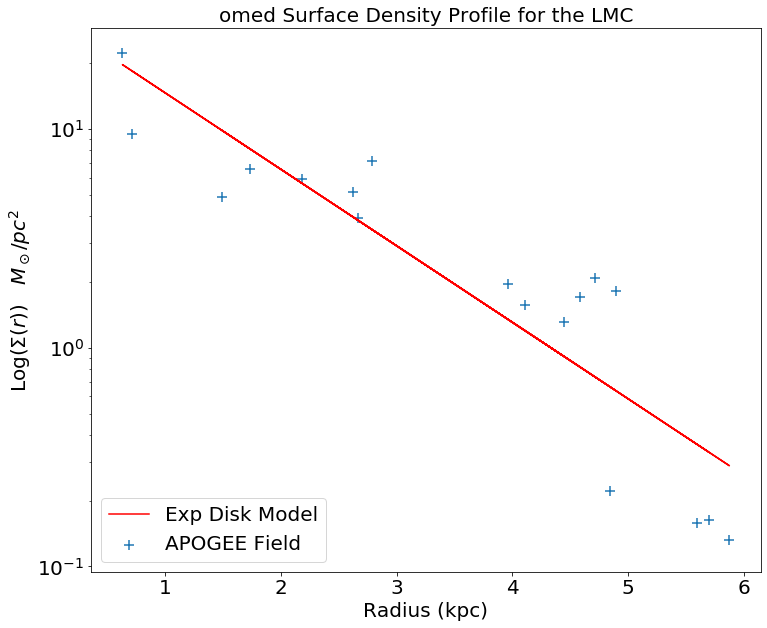

central: 32.747
scale: 1.242
err: 0.152


In [70]:
omed_surfden = []
for i in range(len(omed_field_masses)):
    omed_surfden.append(np.divide(omed_field_masses[i],field_areas[i]))

field_list = [np.where(r13omed['FIELD']=='30Dor'),np.where(r13omed['FIELD']=='LMC1'),
              np.where(r13omed['FIELD']=='LMC2'),np.where(r13omed['FIELD']=='LMC3'),
              np.where(r13omed['FIELD']=='LMC4'),np.where(r13omed['FIELD']=='LMC5'),
              np.where(r13omed['FIELD']=='LMC6'),np.where(r13omed['FIELD']=='LMC7'),
              np.where(r13omed['FIELD']=='LMC8'),np.where(r13omed['FIELD']=='LMC9'),
              np.where(r13omed['FIELD']=='LMC10'),np.where(r13omed['FIELD']=='LMC11'),
              np.where(r13omed['FIELD']=='LMC12'),np.where(r13omed['FIELD']=='LMC13'),
              np.where(r13omed['FIELD']=='LMC14'),np.where(r13omed['FIELD']=='LMC15'),
              np.where(r13omed['FIELD']=='LMC16'),np.where(r13omed['FIELD']=='LMC17')]

omed_radii = []

# for i in range(len(field_str)):
#     omed_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(r13omed['RA'][field_list[i]],
#                                                          r13omed['DEC'][field_list[i]])[0])**2 + 
#                             np.median(dfunc.LMCdisk_cart(r13omed['RA'][field_list[i]],
#                                                          r13omed['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(r13omed['RA'],r13omed['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    omed_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(omed_surfden)>0.0)

omed_radii = np.asarray(omed_radii)[good]
omed_surfden = np.asarray(omed_surfden)[good]


omed_b, omed_m,omed_err = ols_fit(omed_radii,np.log(omed_surfden))

def omedprofile(r):
    return omed_m+np.multiply(omed_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(omed_radii,omed_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(omed_radii)):
#     plt.text(omed_radii[i],omed_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(omed_radii,np.exp(omedprofile(omed_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('omed Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('omedprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(omed_m)))
print('scale: {:.3f}'.format(-np.reciprocal(omed_b)))
print('err: {:.3f}'.format(omed_err[0]/(omed_b)**2))

# old

In [71]:
old_iso_ages = []
old_iso_zs = []

#fnt and brt bins
old_fbins = dfunc.brtfntlmc_bins(r13old)

for i in range(len(field_str)):
    fd = np.where(r13old['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(parage[old][fd]),np.median(r13old[fd]['FE_H']))
    old_iso_ages.append(age)
    old_iso_zs.append(z)

old_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13old['FIELD']==field_str[i]) 
    old_absHs.append(np.asarray(bloopabsH[old])[field_H])

# old_sf_brites = []
# old_sf_faints = []
# for i,j in enumerate(fbins):
#     if i in np.arange(len(old_fbins))[1::2]:
#         old_sf_brites.append(r13old[old_fbins[j]]['SELECTFUNC'])
#     if i in np.arange(len(old_fbins))[0::2]:
#         old_sf_faints.append(r13old[old_fbins[j]]['SELECTFUNC'])

old_sf_brites = []
old_sf_faints = []

for i in field_str:
    fld = np.where(r13old['FIELD']==i)
    
    fnts = np.where(r13old['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13old['TARGET_NAME'][fld]=='BrtRGB')
    
    old_sf_faints.append(r13old['SELECTFUNC'][fld][fnts])
    old_sf_brites.append(r13old['SELECTFUNC'][fld][brts])
        
old_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        old_field_masses.append(dfunc.fieldmass(old_iso_ages[i],old_iso_zs[i],old_absHs[i],old_sf_brites[i],
                                               old_sf_faints[i],parsec))
    except:
        old_field_masses.append(-9999.0)
        
for i in range(len(old_field_masses)):
    if np.isfinite(old_field_masses[i]) == False:
        old_field_masses[i] = -9999.0

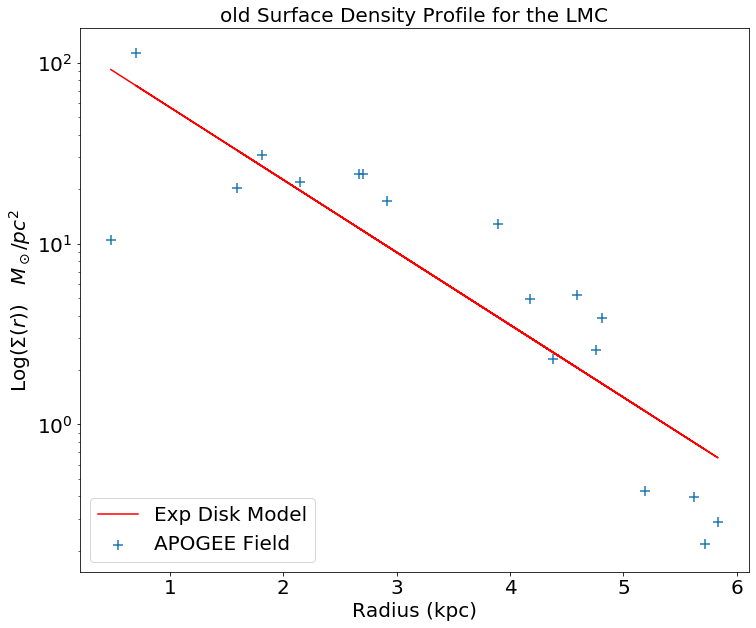

central: 142.922
scale: 1.083
err: 0.151


In [72]:
old_surfden = []
for i in range(len(old_field_masses)):
    old_surfden.append(np.divide(old_field_masses[i],field_areas[i]))

field_list = [np.where(r13old['FIELD']=='30Dor'),np.where(r13old['FIELD']=='LMC1'),
              np.where(r13old['FIELD']=='LMC2'),np.where(r13old['FIELD']=='LMC3'),
              np.where(r13old['FIELD']=='LMC4'),np.where(r13old['FIELD']=='LMC5'),
              np.where(r13old['FIELD']=='LMC6'),np.where(r13old['FIELD']=='LMC7'),
              np.where(r13old['FIELD']=='LMC8'),np.where(r13old['FIELD']=='LMC9'),
              np.where(r13old['FIELD']=='LMC10'),np.where(r13old['FIELD']=='LMC11'),
              np.where(r13old['FIELD']=='LMC12'),np.where(r13old['FIELD']=='LMC13'),
              np.where(r13old['FIELD']=='LMC14'),np.where(r13old['FIELD']=='LMC15'),
              np.where(r13old['FIELD']=='LMC16'),np.where(r13old['FIELD']=='LMC17')]

old_radii = []

# for i in range(len(field_str)):
#     old_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(r13old['RA'][field_list[i]],
#                                                          r13old['DEC'][field_list[i]])[0])**2 + 
#                             np.median(dfunc.LMCdisk_cart(r13old['RA'][field_list[i]],
#                                                          r13old['DEC'][field_list[i]])[1])**2))

x, y, _ = dfunc.LMCdisk_cart(r13old['RA'],r13old['DEC'])
ell = elliptical_radius(x,y)
for i in range(len(field_str)):
    
    old_radii.append(np.median(ell[field_list[i]]))
    
good = np.where(np.asarray(old_surfden)>0.0)

old_radii = np.asarray(old_radii)[good]
old_surfden = np.asarray(old_surfden)[good]


old_b, old_m,old_err = ols_fit(old_radii,np.log(old_surfden))

def oldprofile(r):
    return old_m+np.multiply(old_b,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
# rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(old_radii,old_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# for i in range(len(old_radii)):
#     plt.text(old_radii[i],old_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(old_radii,np.exp(oldprofile(old_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('old Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('oldprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(old_m)))
print('scale: {:.3f}'.format(-np.reciprocal(old_b)))
print('err: {:.3f}'.format(old_err[0]/(old_b)**2))

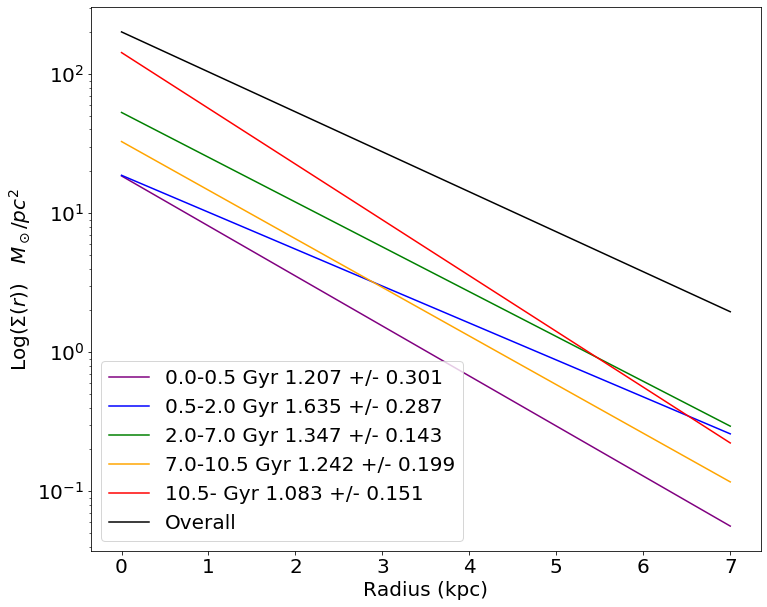

In [73]:
radius = np.linspace(0,7,num=1000)

plt.figure(figsize=[12,10])
plt.plot(radius,np.exp(youngprofile(radius)),
         label='0.0-0.5 Gyr {:.3f} +/- {:.3f}'.format(-np.reciprocal(young_b),young_err[0]/(young_b)**2),c='purple')
plt.plot(radius,np.exp(ylessprofile(radius)),
         label='0.5-2.0 Gyr {:.3f} +/- {:.3f}'.format(-np.reciprocal(yless_b),yless_err[0]/(yless_b)**2),c='blue')
plt.plot(radius,np.exp(ymedprofile(radius)),
         label='2.0-7.0 Gyr {:.3f} +/- {:.3f}'.format(-np.reciprocal(ymed_b),ymed_err[0]/(ymed_b)**2),c='green')
plt.plot(radius,np.exp(omedprofile(radius)),
         label='7.0-10.5 Gyr {:.3f} +/- {:.3f}'.format(-np.reciprocal(omed_b),old_err[0]/(omed_b)**2),c='orange')
plt.plot(radius,np.exp(oldprofile(radius)),
         label='10.5- Gyr {:.3f} +/- {:.3f}'.format(-np.reciprocal(old_b),old_err[0]/(old_b)**2),c='red')

plt.plot(radius,np.exp(lmcdensityprofile(radius)),c='k',label='Overall')

plt.yscale('log')

plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)

plt.legend()
# plt.savefig('ages_desnity_profile',bbox_inches='tight')

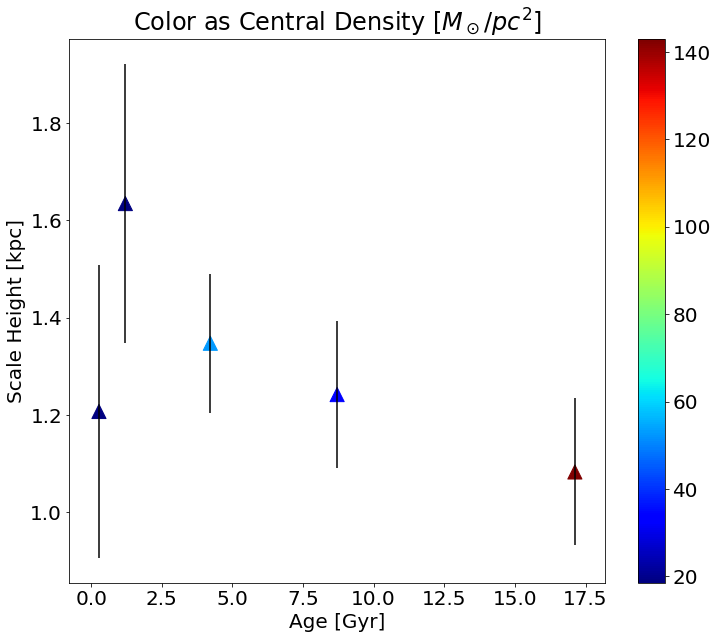

In [74]:
medage = [np.median(10**bloopage[young])/10**9,np.median(10**bloopage[yless])/10**9,
          np.median(10**bloopage[ymed])/10**9,np.median(10**bloopage[omed])/10**9,
          np.median(10**bloopage[old][np.where(bloopage[old]<=10.5)])/10**9]

# sprage = [dfunc.mad(10**bloopage[young])/10**9,dfunc.mad(10**bloopage[yless])/10**9,
#           dfunc.mad(10**bloopage[ymed])/10**9,dfunc.mad(10**bloopage[omed])/10**9,
#           dfunc.mad(10**bloopage[old][np.where(bloopage[old]<=10.5)])/10**9]

heights = [-np.reciprocal(young_b),-np.reciprocal(yless_b),-np.reciprocal(ymed_b),
           -np.reciprocal(omed_b),-np.reciprocal(old_b)]

heights_err = [young_err[0]/(young_b)**2,yless_err[0]/(yless_b)**2,ymed_err[0]/(ymed_b)**2,
               omed_err[0]/(omed_b)**2,old_err[0]/(old_b)**2]

cen_den = [np.exp(young_m),np.exp(yless_m),np.exp(ymed_m),np.exp(omed_m),np.exp(old_m)]

plt.figure(figsize=[12,10])
plt.errorbar(medage,heights,yerr=heights_err,c='k',ls='none')
plt.scatter(medage,heights,marker='^',s=200,c=cen_den,cmap='jet')
plt.colorbar()
plt.xlabel(r'Age [Gyr]')
plt.ylabel(r'Scale Height [kpc]')
plt.title(r'Color as Central Density [$M_\odot/pc^2$]')
plt.savefig('age_scale',bbox_inches='tight')
plt.show()

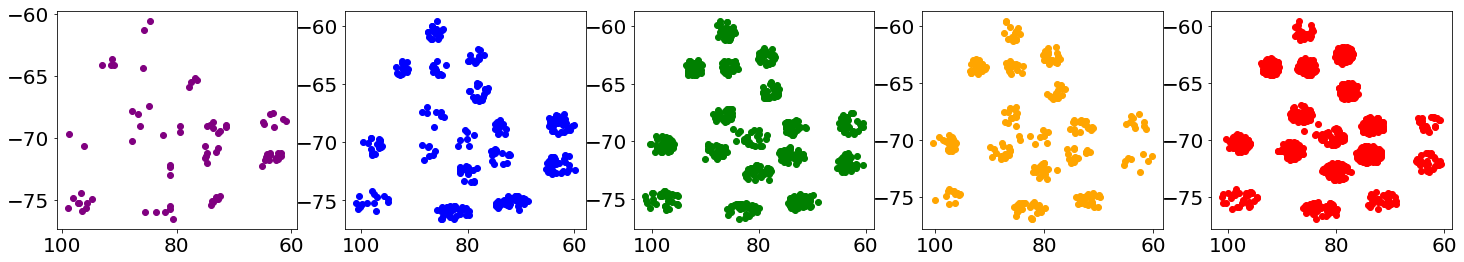

In [75]:
fig = plt.figure(figsize=(25,4))
plt.subplot(1,5,1)
plt.scatter(r13young['RA'],r13young['DEC'],c='purple')
plt.gca().invert_xaxis()

plt.subplot(1,5,2)
plt.scatter(r13yless['RA'],r13yless['DEC'],c='blue')
plt.gca().invert_xaxis()

plt.subplot(1,5,3)
plt.scatter(r13ymed['RA'],r13ymed['DEC'],c='green')
plt.gca().invert_xaxis()

plt.subplot(1,5,4)
plt.scatter(r13omed['RA'],r13omed['DEC'],c='orange')
plt.gca().invert_xaxis()

plt.subplot(1,5,5)
plt.scatter(r13old['RA'],r13old['DEC'],c='red')
plt.gca().invert_xaxis()

plt.savefig('agebins',bbox_inches='tight')

In [129]:
test = fits.getdata('/Users/joshpovick/Downloads/lmcdr16_w_ages.fits')

In [130]:
test.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '39A'
    name = 'ASPCAP_ID'; format = '56A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '105A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '18A'
    name

In [140]:
cat = Table()
# cat.add_column(Column(np.asarray(r13['FIELD']), name='FIELD'))
cat.add_column(Column(np.asarray(r13['RA']), name='RA'))
cat.add_column(Column(np.asarray(r13['DEC']), name='DEC'))
cat.add_column(Column(np.asarray(ms_lg), name='MSL'))
cat.add_column(Column(np.asarray(ms_bg), name='MSB'))
cat.add_column(Column(np.asarray(parage), name='AGE'))
cat.add_column(Column(np.asarray(devscat), name='AGE_ERR'))

cat.write('LMCDR16_AGES.fits')

In [141]:
test2 = fits.getdata('LMCDR16_AGES.fits')

In [142]:
test2.columns

ColDefs(
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'MSL'; format = 'D'
    name = 'MSB'; format = 'D'
    name = 'AGE'; format = 'D'
    name = 'AGE_ERR'; format = 'D'
)